In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import numericalunits as nu

import wimprates as wr

### Convert Xe.dat to nicer format

In [2]:
df = dict()
with open(wr.data_file('migdal/Xe.dat')) as f:
    header = False
    for i, line in enumerate(f.read().splitlines()):
        if 'Principal' in line:
            header = True
            continue
        if 'Energy' in line:
            header = False
            continue
            
        if header:
            n, l = [int(x) for x in line.split()]
        else:
            e, rate = [float(x) for x in line.split()]
            df.setdefault(e, dict())
            df[e]['%d_%d' % (n, l)] = rate
                
df = pd.DataFrame(df).T
df['E'] = df.index

df.to_csv('migdal_transition_ps.csv', index=False)
df_migdal = df
df.head()

,1_0,2_0,2_1,3_0,3_1,3_2,4_0,4_1,4_2,5_0,5_1,E
1.000000,1.013107e-14,2.538509e-13,1.417923e-12,3.745613e-12,1.931796e-11,6.875756e-12,4.272023e-11,2.097481e-10,2.115778e-09,4.937655e-10,5.173118e-07,1.000000
1.045636,1.013389e-14,2.539291e-13,1.424572e-12,3.746781e-12,1.941191e-11,6.950745e-12,4.272690e-11,2.096290e-10,2.124282e-09,4.851036e-10,5.103404e-07,1.045636
1.093354,1.013681e-14,2.540099e-13,1.431461e-12,3.747978e-12,1.950850e-11,7.033516e-12,4.273357e-11,2.095044e-10,2.133447e-09,4.762062e-10,5.031270e-07,1.093354
1.143250,1.013985e-14,2.540935e-13,1.438595e-12,3.749203e-12,1.960773e-11,7.124774e-12,4.274019e-11,2.093738e-10,2.143335e-09,4.670743e-10,4.956689e-07,1.143250
1.195423,1.014299e-14,2.541800e-13,1.445980e-12,3.750456e-12,1.970957e-11,7.225280e-12,4.274673e-11,2.092371e-10,2.154013e-09,4.577099e-10,4.879646e-07,1.195423


Rows are energies, columns are (n, l) states. Data is the differential transition probabilities, at the 1 eV/c reference momentum, not divided by 2 pi.

### Reproduce figure 4

To reproduce figure 4 of https://arxiv.org/pdf/1707.07258.pdf, we must
  * Convert to the other reference momentum of $m_e * .001 c$
  * Divide by 2 pi.
  * Convert eV -> keV; multiply energies by 1e3 and divide differential probabilities by 1e3.

Text(0, 0.5, 'diff. p (keV^-1)')

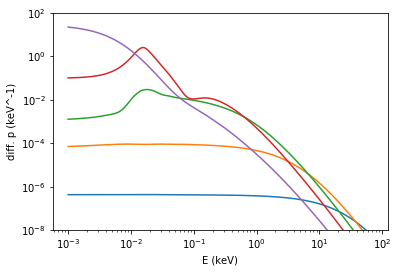

In [3]:
import wimprates

scale = ((nu.me * 1e-3 * nu.c0)/(nu.eV / nu.c0))**2 / (2 * np.pi)

for n in range(1, 6):
    x = df_migdal['%d_0' % n].values.copy()
    for c in wimprates.migdal.migdal_states:
        if c.startswith(str(n)) and not c.endswith('0'):
            x += df[c]
    plt.plot(df['E'] / 1e3, x * scale * 1e3)
#plt.plot(df['E'] / 1e3, df['2_0']**0.5 + df['2_0'])
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8, 1e2)
plt.xlabel("E (keV)")
plt.ylabel("diff. p (keV^-1)")

### Compare with spectrum from LUX talk

To verify we have the correct spectrum, let's compare to a curve trace from slide 10 of a [recent LUX talk](https://indico.cern.ch/event/699961/contributions/3043408/attachments/1692619/2723656/JLIN_Sub_GeV_DM_Talk_IDM2018_V4.pdf)

In [4]:
es = np.logspace(np.log10(5e-2), np.log10(2), 100) *  nu.keV
rs = wr.rate_migdal(
        w=es,
        mw=0.5 * nu.GeV/nu.c0**2,
        sigma_nucleon=1e-35 * nu.cm**2,
        progress_bar=True)

100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Text(0, 0.5, 'dr/dE (keV kg day)^-1')

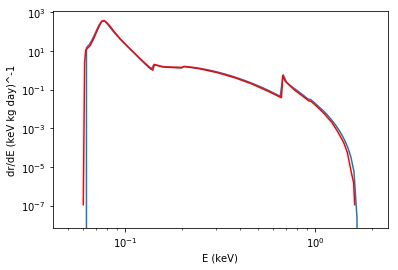

In [5]:
ref_curve = pd.read_csv('migdal_0.5gev_curvetrace_lux.csv', index_col=False)
plt.plot(es / nu.keV, 
         rs * (nu.kg * nu.day * nu.keV))
plt.plot(10**ref_curve['logE'], 10**ref_curve['logR'], color='red', label='Curve trace')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('E (keV)')
plt.ylabel('dr/dE (keV kg day)^-1')

Looks good! The remaining deviations look like curve tracing artifacts.